Initially 2274 rows.
596 rows have missing EDSS values and will be dropped...


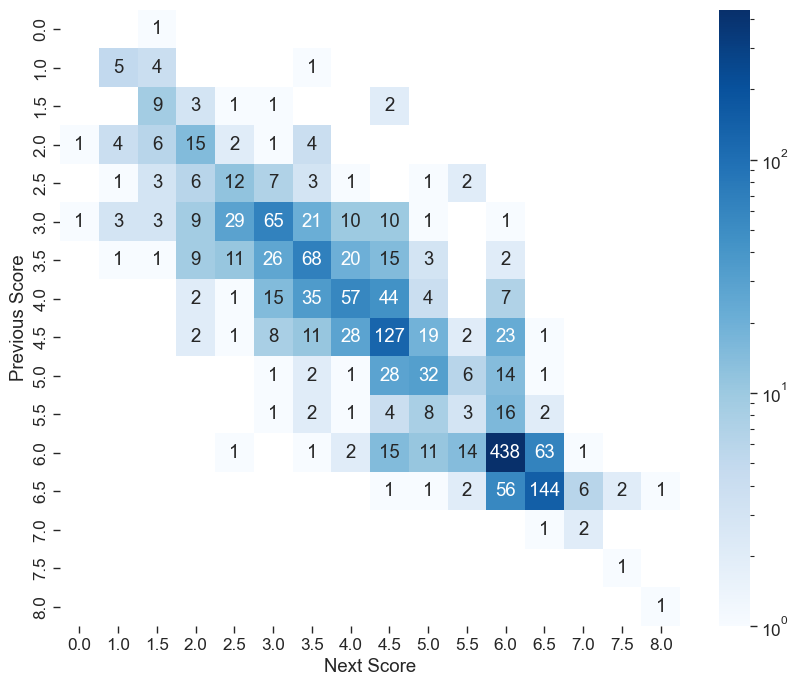

886 rows have a previous EDSS >= 5.0 and will be dropped...
60 rows have a previous EDSS < 2.5 and will be dropped...
39 rows have missing DMOs and will be dropped...
We have 63 progressions across 58 subjects, out of a total of 693 valid samples.


,Local.Participant,visit.number,EDFSCR1L,Prev_EDSS,Prev_Timepoint,progression,wb_all_sum_w,walkdur_all_sum_w,wbsteps_all_sum_w,wbdur_all_avg_w,...,ws_30_avg_w,strlen_30_avg_w,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w
29,10382,T2,6.0,4.0,T1,1,340.0,74.0,6773.0,8.4,...,0.84,106.0,94.0,1.25,1.00,103.0,17.0,16.0,7.0,7.0
46,10385,T4,6.0,4.5,T3,1,141.0,54.0,4949.0,10.9,...,0.96,116.0,98.0,1.16,1.12,109.0,18.0,14.0,10.0,7.0
74,10393,T2,5.0,4.0,T1,1,491.0,97.0,7743.0,8.2,...,0.83,118.0,84.0,1.35,1.03,98.0,19.0,13.0,3.0,7.0
77,10393,T5,6.0,4.5,T4,1,395.0,82.0,6761.0,8.5,...,0.86,120.0,84.0,1.34,1.07,100.0,19.0,11.0,4.0,7.0
213,21138,T3,5.0,3.0,T2,1,216.0,39.0,3362.0,7.8,...,0.83,111.0,88.0,1.28,0.97,95.0,19.0,14.0,2.0,7.0


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import os
from dotenv import load_dotenv
from prometheus_client.decorator import n_args

load_dotenv()

data_dir = os.getenv("DATA_DIR", "Dataset/")
min_prev_score = 0
threshold = 5.0

# read in main MS dataset
label_file_path = data_dir + r"MS_dataset_v.7.3.csv"
labels_df = pd.read_csv(label_file_path, usecols=['Local.Participant', 'EDFSCR1L', 'visit.number'])

# Crop down to just the necessary columns
labels_df = labels_df.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
labels_df['Prev_EDSS'] = labels_df.groupby('Local.Participant')['EDFSCR1L'].shift(1)
labels_df['Prev_Timepoint'] = labels_df.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (labels_df['Prev_EDSS'] < threshold) & (labels_df['EDFSCR1L'] >= threshold)
labels_df['progression'] = np.where(progression_mask, 1, 0)

transitions = labels_df[progression_mask]  # all the data where a transition happens, just in case.

labels_df['Prev_Timepoint'] = labels_df['Prev_Timepoint'].str.upper()  # needed for later merges
labels_df['visit.number'] = labels_df['visit.number'].str.upper()  # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"]  # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = data_dir + f"/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
labels_df = pd.merge(labels_df, features_df, left_on=['Local.Participant', 'Prev_Timepoint'],
                     right_on=['participant_id', 'visit_type'], how='left')

labels_df = labels_df.drop(['participant_id', 'visit_type'], axis=1)
labels_df = labels_df.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(labels_df)} rows.")

# get rid of participants where either current or previous EDSS is missing
count_before = len(labels_df)
labels_df = labels_df.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(labels_df)} rows have missing EDSS values and will be dropped...")

# Create matrix of prev -> next EDSS scores
prev_scores = labels_df['Prev_EDSS'].to_numpy().tolist()
next_scores = labels_df['EDFSCR1L'].to_numpy().tolist()

# extract the unique scores
scores = list(set(prev_scores).union(set(next_scores)))
scores.sort()
n_scores = len(scores)

# Create transition matrix
transition_matrix = pd.DataFrame(
    np.zeros((n_scores, n_scores),dtype=int),
    index=scores,
    columns=scores)

for prev_score, next_score in zip(prev_scores ,next_scores):
    transition_matrix.loc[prev_score, next_score] += 1

# Pretty print transition matrix as heatmap
plt.subplots(figsize=(10,8))
ax=plt.subplot(111)
sns.heatmap(transition_matrix.values, annot=True, cmap="Blues", ax=ax, fmt='g', norm=colors.LogNorm())
ax.set_xlabel('Next Score')
ax.set_ylabel('Previous Score')
ax.xaxis.set_ticklabels(scores)
ax.yaxis.set_ticklabels(scores)
plt.show()

# Exclude participants with Prev_EDSS > threshold as they have already progressed:
count_before = len(labels_df)
high_prev_edss_mask = (labels_df['Prev_EDSS'] >= threshold)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS >= {threshold} and will be dropped...")
labels_df = labels_df.drop(labels_df[high_prev_edss_mask].index)

# Exclude participants with Prev_EDSS < min_prev_score as they are highly unlikely to progress, and may have different mobility patterns
count_before = len(labels_df)
low_prev_edss_mask = (labels_df['Prev_EDSS'] < min_prev_score)
print(f"{sum(low_prev_edss_mask)} rows have a previous EDSS < {min_prev_score} and will be dropped...")
labels_df = labels_df.drop(labels_df[low_prev_edss_mask].index)

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(labels_df)
labels_df = labels_df.dropna()
print(f"{count_before - len(labels_df)} rows have missing DMOs and will be dropped...")

num_progressions = len(labels_df[labels_df["progression"] == 1])
unique_sub_progressions = len(labels_df[labels_df["progression"] == 1]['Local.Participant'].unique())

print(
    f"We have {num_progressions} progressions across {unique_sub_progressions} subjects, out of a total of {len(labels_df)} valid samples.")

display(labels_df[labels_df["progression"] == 1].head(5))

#labels_df.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

# undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

strdur_30_avg_w      0.374633
strdur_all_avg_w     0.180610
strdur_all_var_w     0.086202
strlen_30_var_w      0.027608
wbdur_all_avg_w      0.007628
wbdur_all_p90_w     -0.043022
strlen_1030_avg_w   -0.050695
wb_30_sum_w         -0.090144
wb_60_sum_w         -0.103613
ws_30_var_w         -0.142686
wb_10_sum_w         -0.164781
strlen_30_avg_w     -0.169995
wb_all_sum_w        -0.181318
walkdur_all_sum_w   -0.213052
n_days_w            -0.218103
cadence_all_var_w   -0.218299
wbsteps_all_sum_w   -0.266802
ws_1030_avg_w       -0.277691
wbdur_all_var_w     -0.298873
cadence_all_avg_w   -0.305847
ws_10_p90_w         -0.377305
ws_30_avg_w         -0.438641
ws_30_p90_w         -0.448290
cadence_30_avg_w    -0.474054
cadence_30_p90_w    -0.479445
dtype: float64

Index(['cadence_30_p90_w', 'cadence_30_avg_w', 'ws_30_p90_w', 'ws_30_avg_w',
       'ws_10_p90_w', 'strdur_30_avg_w', 'cadence_all_avg_w',
       'wbdur_all_var_w', 'ws_1030_avg_w'],
      dtype='str')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

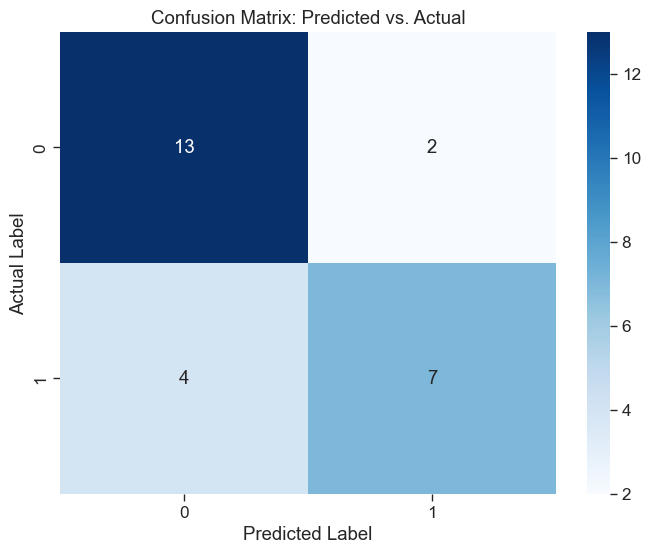

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

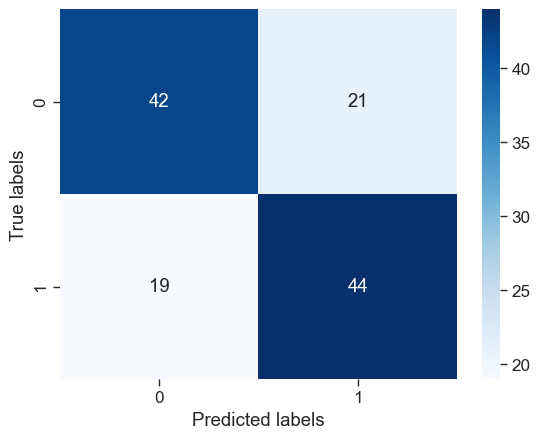

In [83]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# drop irrelevant or 'cheating' columns
labels_y = labels_df["progression"].reset_index(drop=True)
labels_X_all = labels_df.reset_index(drop=True)
labels_X = labels_df.drop(["progression", "Local.Participant", "EDFSCR1L",
                           "visit.number", "Prev_EDSS", "Prev_Timepoint"], axis=1)

rus = RandomUnderSampler(random_state=None)
ros = RandomOverSampler(random_state=None)

resampled_X, resampled_y = rus.fit_resample(labels_X, labels_y)

# feature importance analysis
pearson_corr = resampled_X.corrwith(resampled_y).sort_values(ascending=False)
display(pearson_corr)

top_10_features = resampled_X.corrwith(resampled_y).abs().sort_values(ascending = False).iloc[0:9].index
display(top_10_features)

# train test split
X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.2, random_state=42)

# normalisation
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")

# evaluate
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix: Predicted vs. Actual')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Run 5-fold cross-validation

# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', model)
])

scores = cross_val_score(pipeline, resampled_X, resampled_y, cv=5, scoring='accuracy')
print(scores)
print('Model accuracy score : {0:0.4f}'.format(scores.mean()))

# Visualisation od the results in confusion matrix
# Annoyingly cross_val_score and cross_val_predict can differ ???

y_pred = cross_val_predict(pipeline, resampled_X, resampled_y, cv=5)
conf_mat = confusion_matrix(resampled_y, y_pred)

# Pretty print confusion matrix

ax = plt.subplot()

confusion_matrix = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", ax=ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

In [54]:
from sklearn.svm import SVC

svm_model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),      # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']), # Type of kernel
        'degree': Integer(1, 5)                          # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.neural_network import MLPClassifier

mlp_model = BayesSearchCV(
    MLPClassifier(random_state=42, max_iter=1000),
    {
        'hidden_layer_sizes': Integer(1, 128), # Different architectures
        'activation': Categorical(['tanh', 'relu']),
        'solver': Categorical(['sgd', 'adam']),
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),      # L2 penalty (regularization)
        'learning_rate': Categorical(['constant', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform') # Initial learning rate
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.neighbors import KNeighborsClassifier

knn_model = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': Integer(1, 50),
        'weights': Categorical(['uniform', 'distance']),
        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': Integer(10, 50),         
        'p': Integer(1, 2)                    # 1 = Manhattan, 2 = Euclidean distance
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from xgboost import XGBClassifier

xgb_model = BayesSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'subsample': Real(0.5, 1.0, prior='uniform'),        # Fraction of samples used for fitting
        'colsample_bytree': Real(0.5, 1.0, prior='uniform'), # Fraction of features used per tree
        'gamma': Real(1e-6, 5, prior='log-uniform'),         # Min loss reduction for split
        'reg_alpha': Real(1e-5, 10, prior='log-uniform'),    # L1 regularization
        'reg_lambda': Real(1e-5, 10, prior='log-uniform')    # L2 regularization
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.ensemble import RandomForestClassifier

rf_model = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]), # Number of features to consider at each split
        'bootstrap': Categorical([True, False]),
        'criterion': Categorical(['gini', 'entropy'])
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.tree import DecisionTreeClassifier

dt_model = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(3, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'ccp_alpha': Real(0.0, 0.1, prior='uniform') # Cost-Complexity Pruning alpha
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.linear_model import LogisticRegression

lr_model = BayesSearchCV(
    LogisticRegression(random_state=42, solver='saga', max_iter=5000), 
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),   # Inverse of regularization strength
        'penalty': Categorical(['l1', 'l2', 'elasticnet']), 
        'l1_ratio': Real(0, 1, prior='uniform'),      # Only used if penalty='elasticnet'
        'fit_intercept': Categorical([True, False])
    },
    n_iter=20,
    random_state=42,
    verbose=0,
    n_jobs=-1,
    cv=5
)


Training SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidate

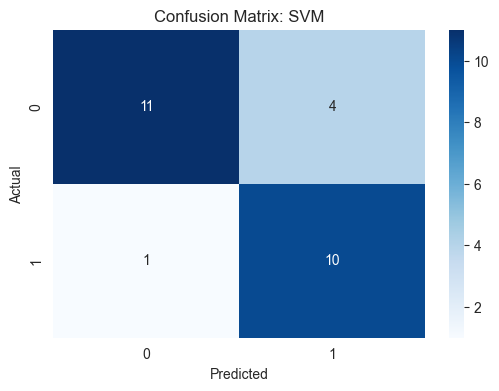


Training MLP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best CV Score: 0.7400
Test Accuracy: 0.7308

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.67      0.73      0.70        11

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26



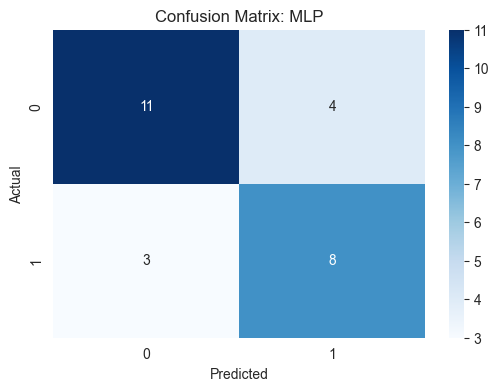


Training KNN...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidate

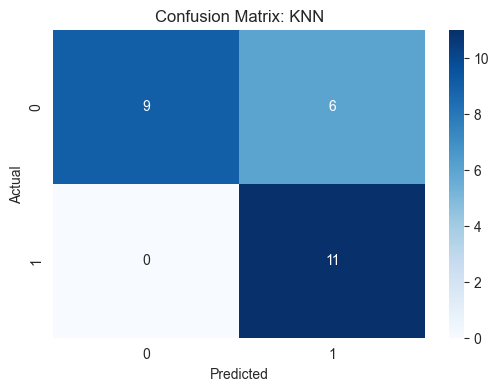


Training XGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [16:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_labe

Best CV Score: 0.7100
Test Accuracy: 0.6538

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.58      0.64      0.61        11

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.66      0.65      0.66        26



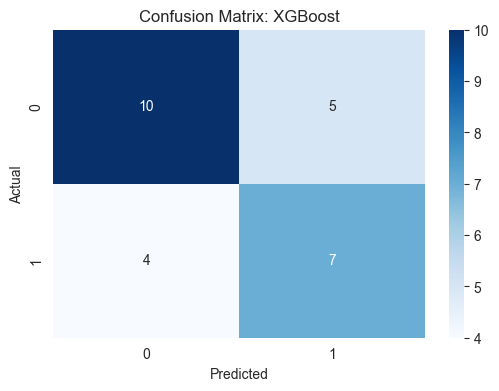


Training Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1

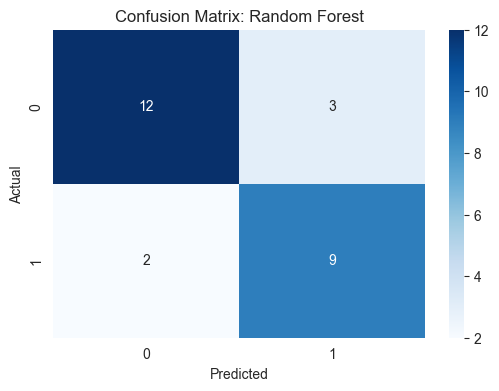


Training Decision Tree...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1

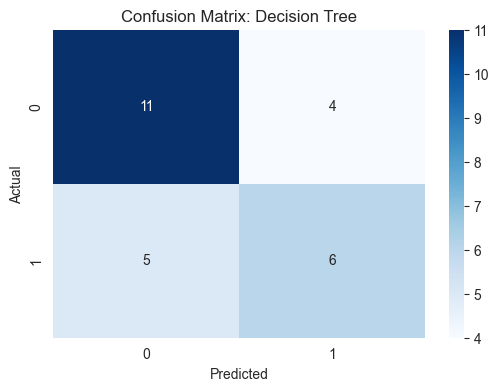


Training Logistic Regression...


/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. 

Best CV Score: 0.7200
Test Accuracy: 0.8077

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.71      0.91      0.80        11

    accuracy                           0.81        26
   macro avg       0.82      0.82      0.81        26
weighted avg       0.83      0.81      0.81        26



/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l2 with l1_ratio=0.021531503559764565. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/nsi/.virtualenvs/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was depre

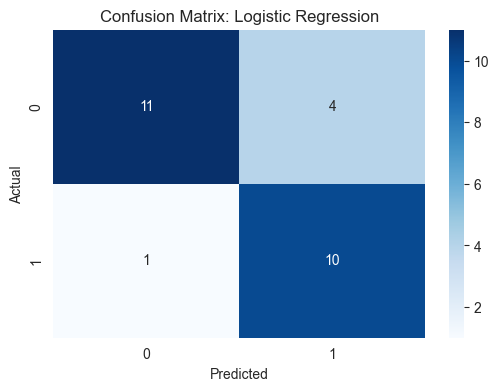

training best model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 can

,Model,Best Score (CV),Accuracy,Precision,Recall,F1 Score,Best Params
4,Random Forest,0.74,0.807692,0.811813,0.807692,0.808557,"{'bootstrap': True, 'criterion': 'gini', 'max_..."
0,SVM,0.71,0.807692,0.831044,0.807692,0.808547,"{'C': 23585.586304948225, 'degree': 5, 'gamma'..."
6,Logistic Regression,0.72,0.807692,0.831044,0.807692,0.808547,"{'C': 0.23031867224232325, 'fit_intercept': Tr..."
2,KNN,0.73,0.769231,0.850679,0.769231,0.765110,"{'algorithm': 'brute', 'leaf_size': 38, 'n_nei..."
1,MLP,0.74,0.730769,0.735348,0.730769,0.731980,"{'activation': 'relu', 'alpha': 4.869521028037..."
3,XGBoost,0.71,0.653846,0.658883,0.653846,0.655403,"{'colsample_bytree': 0.8670140089927842, 'gamm..."
5,Decision Tree,0.70,0.653846,0.650481,0.653846,0.651188,"{'ccp_alpha': 0.006889811969673507, 'criterion..."


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


def fit_and_evaluate(model, model_name, X_train, X_test, y_train, y_test, labels_X, labels_y):
    print(f"\n{'='*40}")
    print(f"Training {model_name}...")
    print(f"{'='*40}")

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    model_performance.append({
        'Model': model_name,
        'Best Score (CV)': model.best_score_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Params': model.best_params_
    })
    
    print(f"Best CV Score: {model.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# all models in one dict with names
models_dict = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": lr_model
}

model_performance = []

for name, model in models_dict.items():
    fit_and_evaluate(model, name, X_train, X_test, y_train, y_test, resampled_X, resampled_y)

results_df = pd.DataFrame(model_performance)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# get best model and retrain
print("training best model...")
best_model = models_dict[results_df["Model"].iloc[0]]
best_model.fit(X_train, y_train)

print("\nModel Comparison Table:")
display(results_df)

In [57]:
# un-normalise the data and try to find out which samples were misclassified
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

indexed_train_predictions = y_train.reset_index()
indexed_train_predictions["Prediction"] = train_predictions
indexed_train_predictions.index = indexed_train_predictions["index"]
indexed_train_predictions = indexed_train_predictions.drop(["index"], axis=1)

indexed_test_predictions = y_test.reset_index()
indexed_test_predictions["Prediction"] = test_predictions
indexed_test_predictions.index = indexed_test_predictions["index"]
indexed_test_predictions = indexed_test_predictions.drop(["index"], axis=1)

predictions_to_be_appended = pd.concat([indexed_train_predictions, indexed_test_predictions], axis=0)
predictions_to_be_appended["misclassified"] = abs(predictions_to_be_appended["Prediction"] - predictions_to_be_appended["progression"])
predictions_to_be_appended = predictions_to_be_appended.drop(["progression"], axis=1)

original_data_with_predictions = labels_X_all.join(predictions_to_be_appended)

display(original_data_with_predictions[original_data_with_predictions["misclassified"] == 1])

,Local.Participant,visit.number,EDFSCR1L,Prev_EDSS,Prev_Timepoint,progression,wb_all_sum_w,walkdur_all_sum_w,wbsteps_all_sum_w,wbdur_all_avg_w,...,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w,Prediction,misclassified
1,24081,T4,4.0,4.0,T3,0,239.0,53.0,4793.0,8.7,...,88.0,1.17,1.12,99.0,25.0,18.0,3.0,7.0,1,1
2,24154,T5,3.0,2.5,T4,0,355.0,69.0,5885.0,7.4,...,86.0,1.24,1.09,97.0,30.0,29.0,4.0,7.0,1,1
6,25033,T2,4.5,4.5,T1,0,317.0,60.0,4831.0,8.3,...,87.0,1.33,1.06,95.0,24.0,20.0,3.0,5.0,1,1
11,24011,T2,4.0,3.0,T1,0,449.0,90.0,7642.0,7.7,...,85.0,1.28,0.87,93.0,23.0,19.0,6.0,7.0,1,1
12,24663,T5,4.5,4.5,T4,0,313.0,59.0,5246.0,6.9,...,94.0,1.24,0.71,101.0,14.0,10.0,6.0,7.0,1,1
21,25233,T4,4.5,4.5,T3,0,247.0,49.0,3670.0,8.4,...,79.0,1.46,0.91,85.0,18.0,15.0,1.0,7.0,1,1
22,24567,T2,2.5,3.5,T1,0,378.0,69.0,6122.0,7.6,...,93.0,1.16,0.93,103.0,19.0,15.0,4.0,7.0,1,1
31,24563,T5,3.5,3.5,T4,0,204.0,30.0,2541.0,7.0,...,88.0,1.28,1.01,92.0,13.0,16.0,1.0,5.0,1,1
35,25236,T4,4.5,3.0,T3,0,394.0,62.0,6133.0,6.6,...,88.0,1.09,0.96,100.0,27.0,20.0,2.0,4.0,1,1
37,25166,T4,4.5,4.5,T3,0,314.0,98.0,8866.0,7.9,...,92.0,1.30,0.87,100.0,14.0,9.0,17.0,7.0,1,1


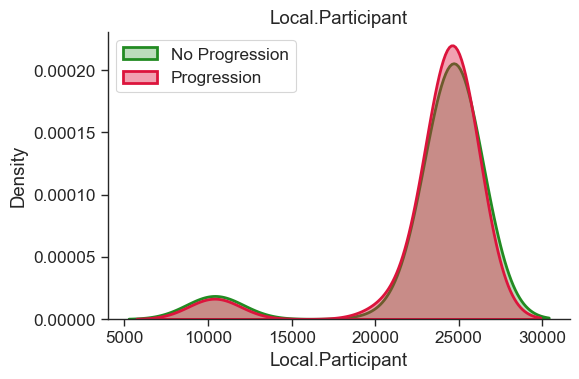

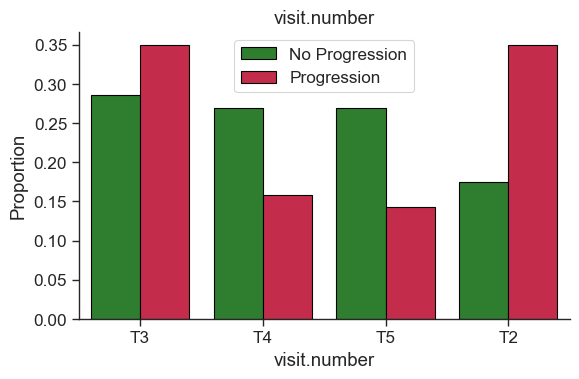

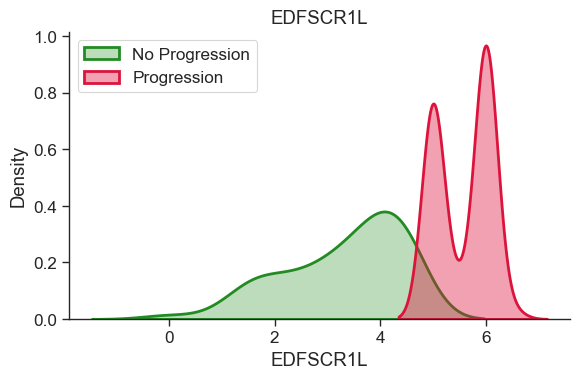

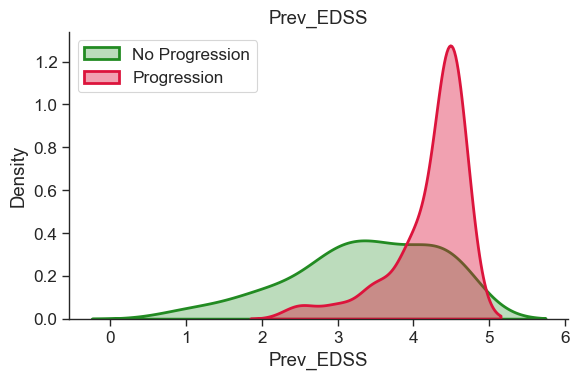

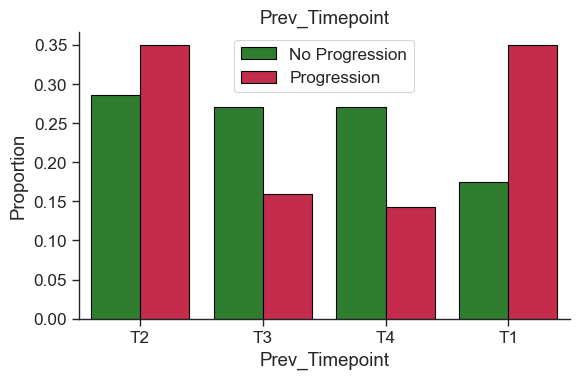

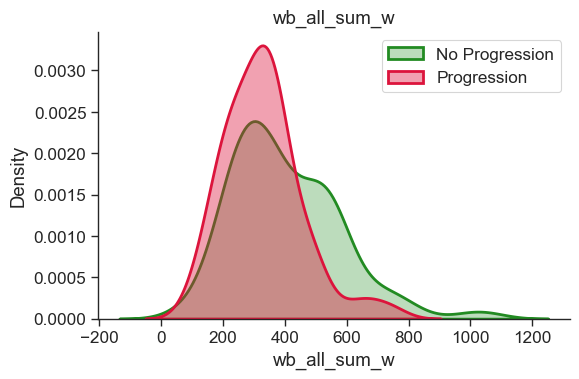

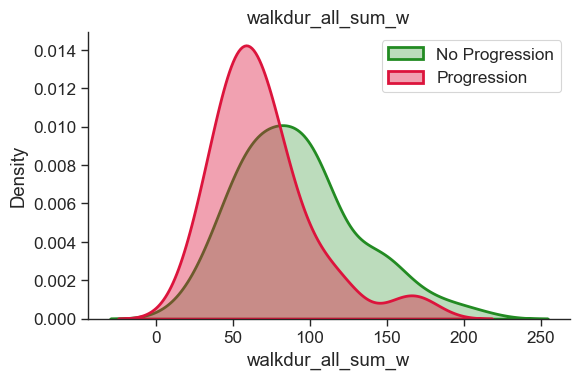

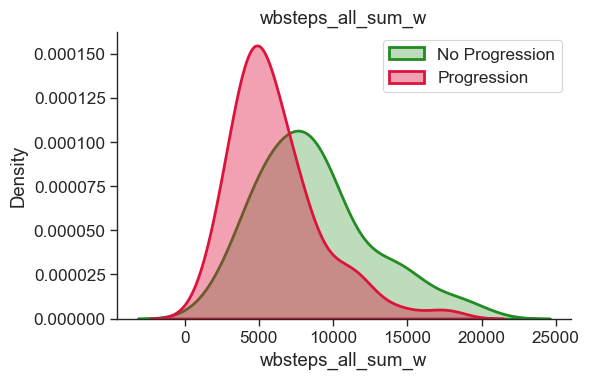

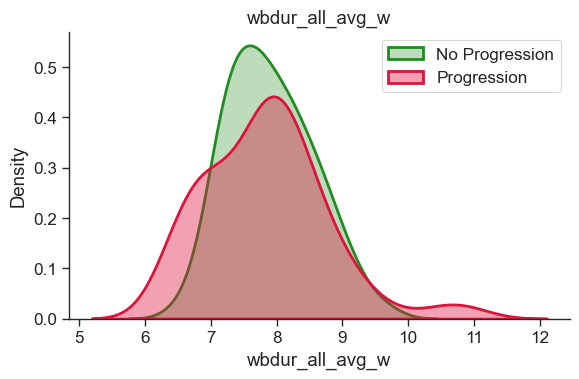

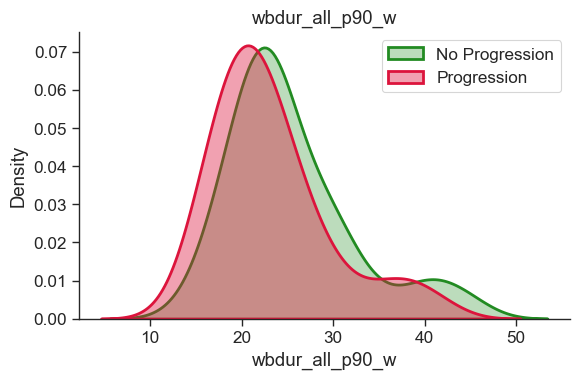

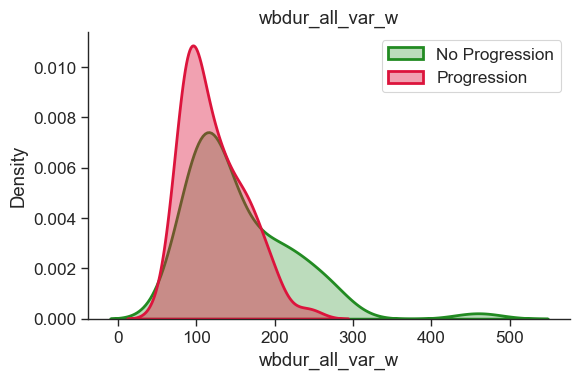

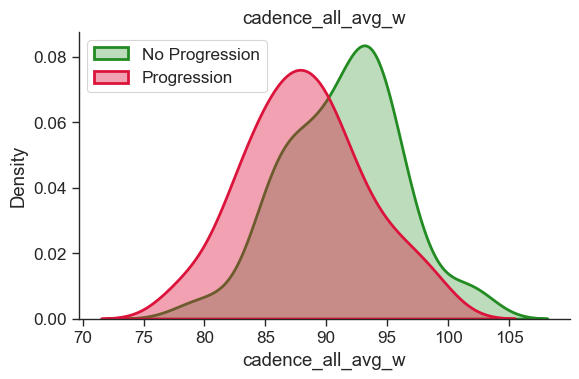

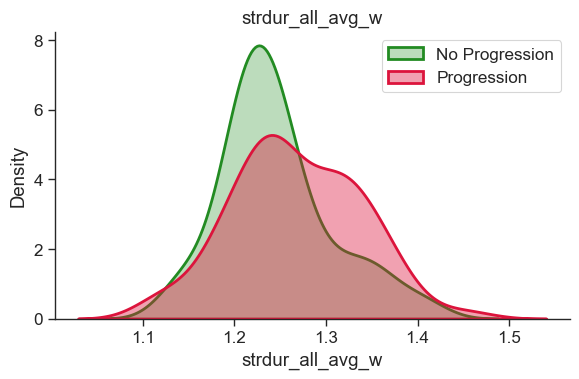

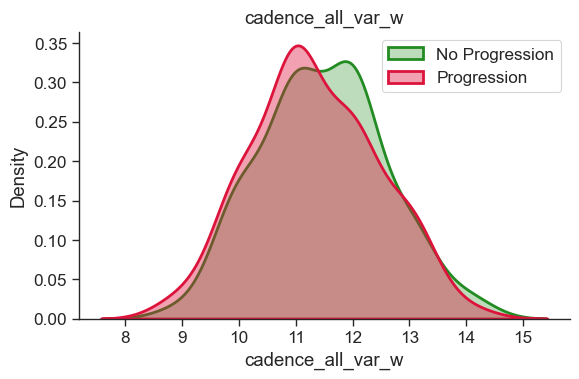

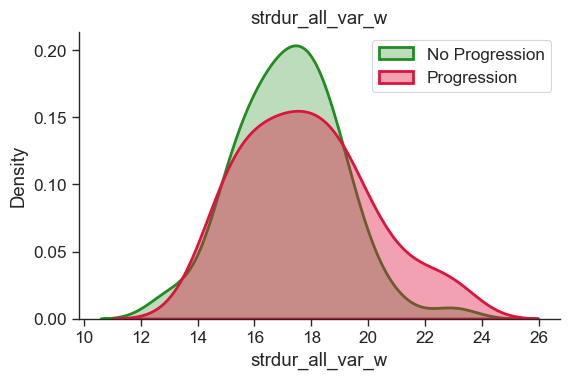

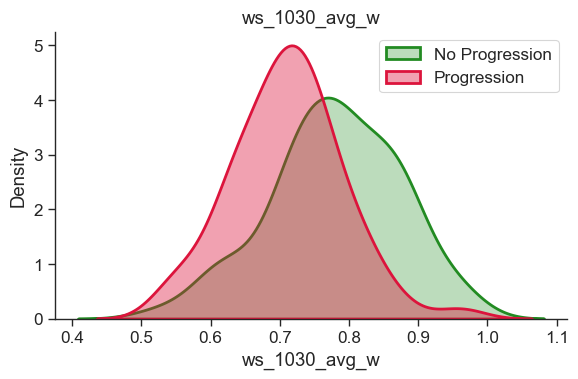

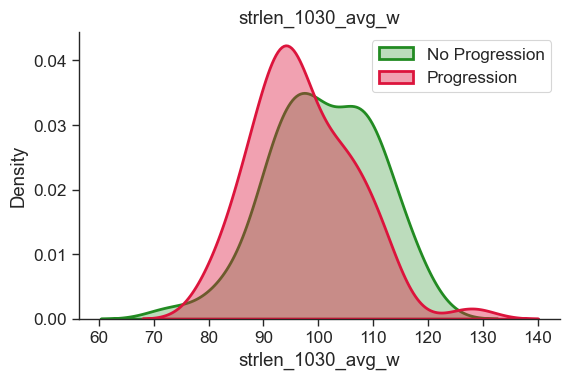

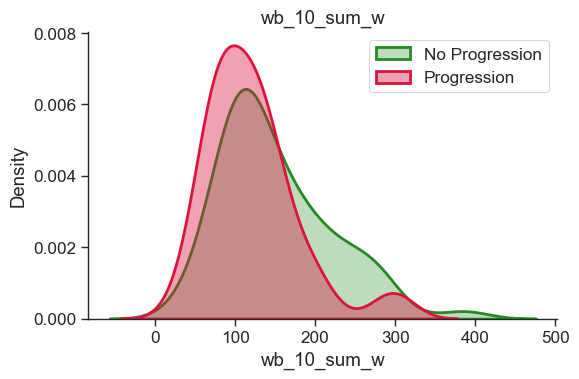

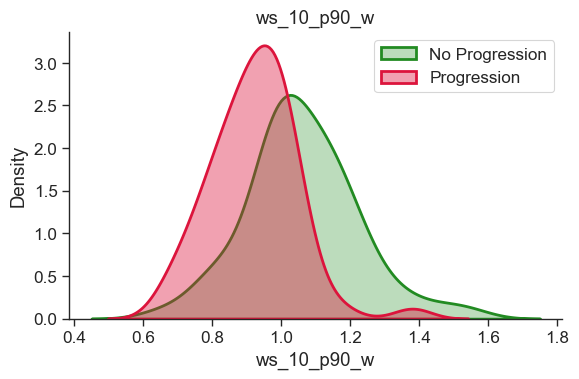

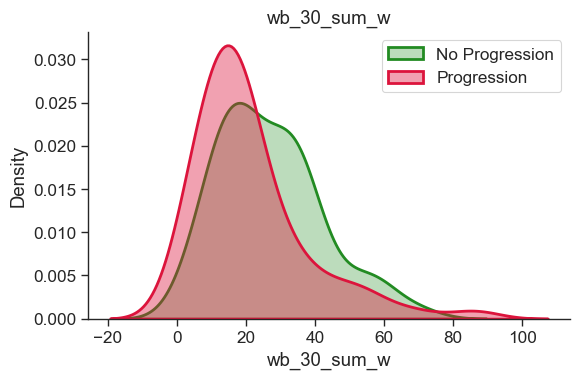

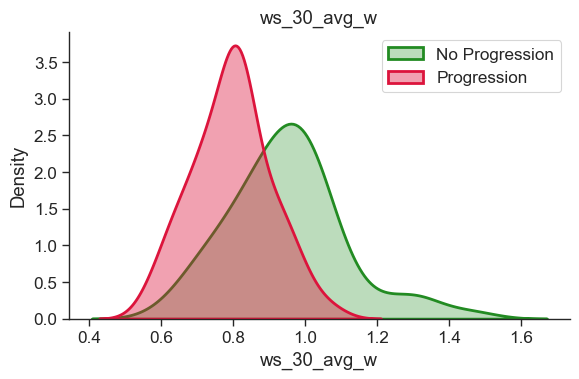

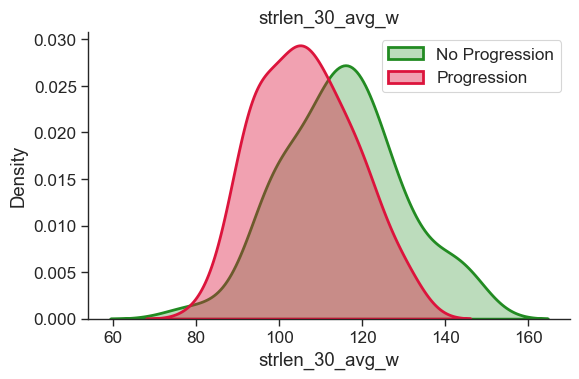

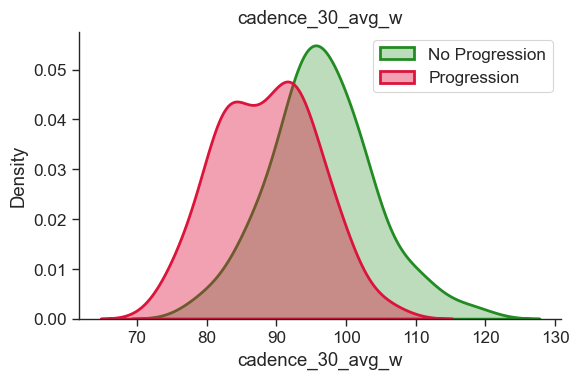

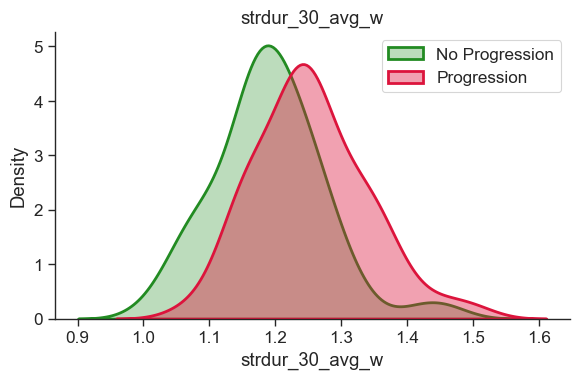

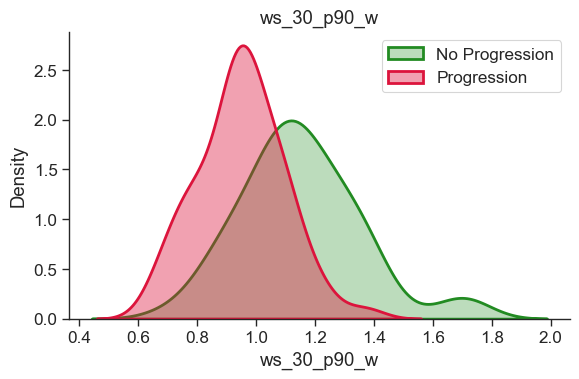

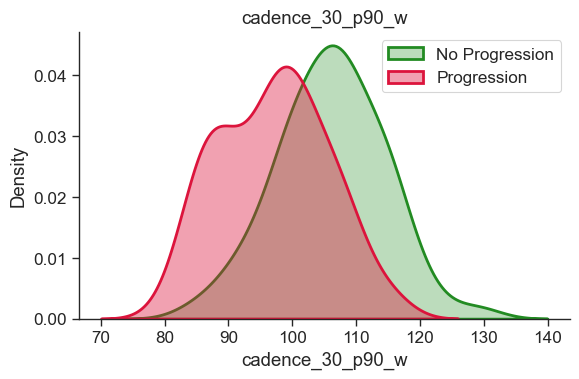

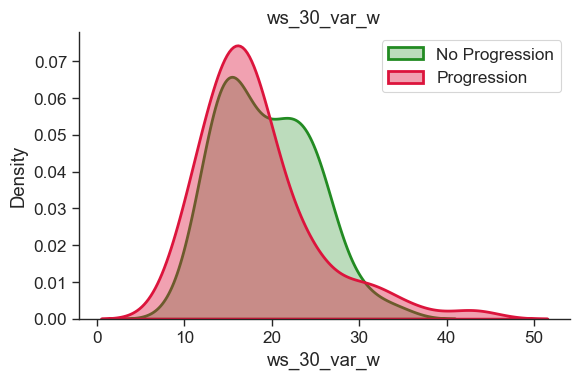

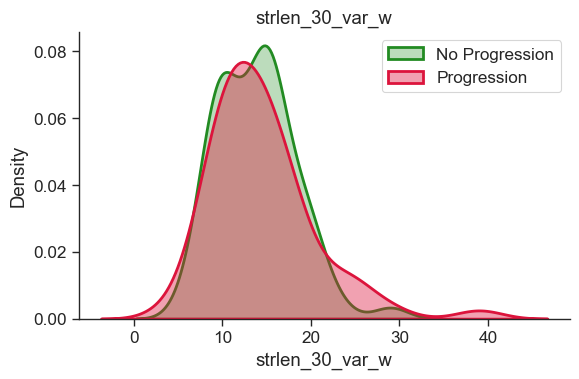

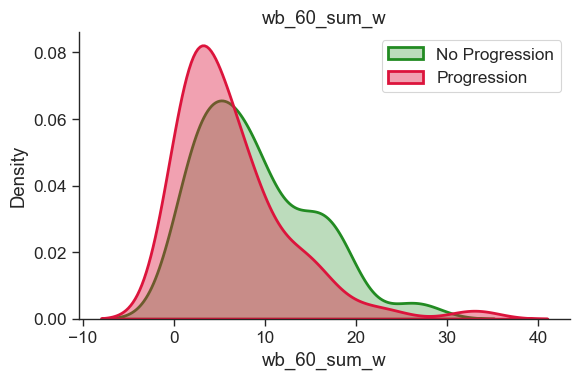

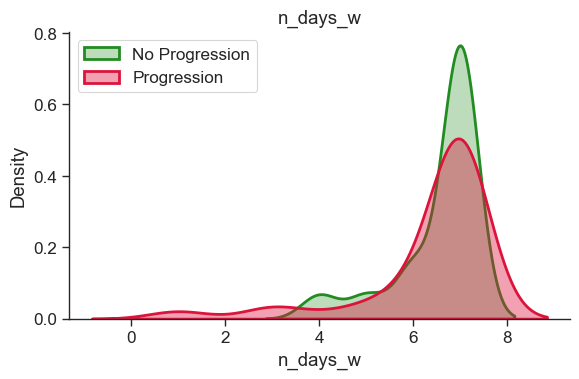

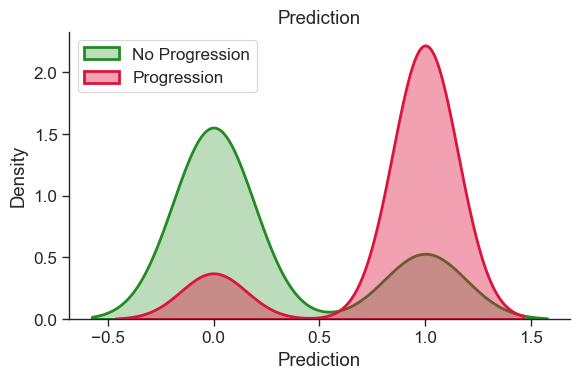

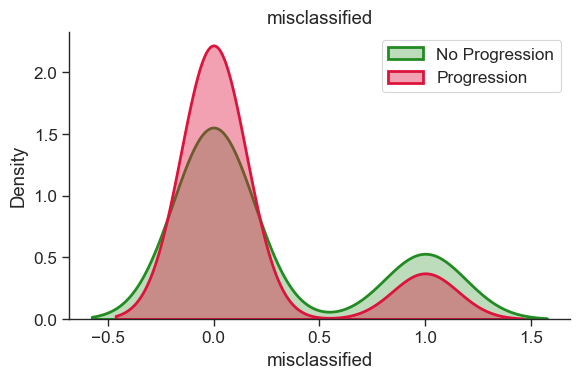

In [58]:
sns.set_style("ticks") 
sns.set_context("paper", font_scale=1.4)

prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 1]
no_prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 0]

feature_cols = [c for c in original_data_with_predictions.columns if c != "progression"]

for col in feature_cols:
    plt.figure(figsize=(6, 4))
    
    if pd.api.types.is_numeric_dtype(original_data_with_predictions[col]):
        
        sns.kdeplot(data=no_prog_group, x=col, fill=True, 
                    color='forestgreen', label='No Progression', alpha=0.3, linewidth=2)
        sns.kdeplot(data=prog_group, x=col, fill=True, 
                    color='crimson', label='Progression', alpha=0.4, linewidth=2)
        
        plt.ylabel('Density')
        plt.legend()
        
    else:
        temp_df = original_data_with_predictions.groupby('progression')[col].value_counts(normalize=True).rename('proportion').reset_index()
        temp_df['progression_label'] = temp_df['progression'].map({0: 'No Progression', 1: 'Progression'})
        
        sns.barplot(data=temp_df, x=col, y='proportion', hue='progression_label', 
                    palette={'No Progression': 'forestgreen', 'Progression': 'crimson'}, edgecolor='black')
        
        plt.ylabel('Proportion')
        plt.legend(title=None)

    plt.title(f'{col}') 
    plt.xlabel(col)
    
    sns.despine()
    
    plt.tight_layout()
    plt.show()